In [2]:
import librosa
import numpy as np
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import os

In [3]:

def extract_features_optimized(file_path, flag):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, duration=30) # Load up to 30 seconds
        
        # 1. MFCCs (Mean) - Captures Timbre
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        # 2. Delta MFCCs (Mean) - Captures Vocal Dynamics
        delta_mfccs = librosa.feature.delta(mfccs)
        delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
        delta_mfccs_std = np.std(delta_mfccs, axis=1)

        # 3. Delta-Delta MFCCs (Mean) - Captures Acceleration of Dynamics
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
        delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

        # 4. Chroma Features (Mean) - Captures Harmonic Profile
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chromagram, axis=1)

        # 5. F0 / Pitch (Standard Deviation) - Captures Vibrato & Pitch Stability
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        # Get statistics only on the voiced frames where F0 is reliable
        voiced_f0 = f0[voiced_flag]
        if len(voiced_f0) > 0:
            f0_std = np.std(voiced_f0)
        else:
            f0_std = 0 # If no voice is detected, vibrato/stability is 0
        f0_std_feature = np.array([f0_std]) # Make it a 1-element array

        # 6. Spectral Centroid (Mean) - Captures "Brightness"
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_centroid_mean = np.mean(spec_centroid, axis=1)
        spec_centroid_std = np.std(spec_centroid, axis=1)

        # 7. Zero-Crossing Rate (Mean) - Captures Noisiness/Breathiness
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr, axis=1)
        zcr_std = np.std(zcr, axis=1)
        
        # 8. RMS Energy (Mean) - Captures Average Loudness
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms, axis=1)
        rms_std = np.std(rms, axis=1)

        # 9. Spectral Bandwidth (Mean) - Captures "Fullness"
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_bw_mean = np.mean(spec_bw, axis=1)
        spec_bw_std = np.std(spec_bw, axis=1)
        
        # # 10. Spectral Contrast (Mean) - Captures Timbre Variation
        # spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        # spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
        # spectral_contrast_std = np.std(spectral_contrast, axis=1)
        
        # 11. CQT (Constant-Q Transform) - Captures Harmonic Content
        cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        cqt_mean = np.mean(cqt, axis=1)
        cqt_std = np.std(cqt, axis=1)
        
        # 12. Tonnetz (Tonal Centroid Features) - Captures Harmonic Relations
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        tonnetz_mean = np.mean(tonnetz, axis=1)
        tonnetz_std = np.std(tonnetz, axis=1)
        
        # # 13. Spectral Flatness (Mean) - Captures Noise vs Tonal Content
        # spectral_flatness = librosa.feature.spectral_flatness(y=y)
        # spectral_flatness_mean = np.mean(spectral_flatness, axis=1)
        # spectral_flatness_std = np.std(spectral_flatness, axis=1)
        
        # # 14. Spectral Rolloff (Mean) - Captures High-Frequency Content
        # spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        # spectral_rolloff_mean = np.mean(spectral_rolloff, axis=1)
        # spectral_rolloff_std = np.std(spectral_rolloff, axis=1)
        
               
        
        # Combine all features into a single vector
        combined_features = np.hstack([
            mfccs_mean,
            mfccs_std,
            delta_mfccs_mean,
            delta_mfccs_std,
            delta2_mfccs_mean,
            delta2_mfccs_std,
            chroma_mean,
            f0_std_feature,
            spec_centroid_mean,
            spec_centroid_std,
            zcr_mean,
            zcr_std,
            rms_mean,
            rms_std,
            spec_bw_mean,
            spec_bw_std,
            # spectral_contrast_mean,
            # spectral_contrast_std,
            cqt_mean,
            cqt_std,
            tonnetz_mean,
            tonnetz_std,
            # spectral_flatness_mean,
            # spectral_flatness_std
            # spectral_rolloff_mean,
            # spectral_rolloff_std
        ])
        
        # Ensure there are no NaN values
        combined_features = np.nan_to_num(combined_features)

        return combined_features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return a zero vector of the expected size if an error occurs
        # Expected size: 20(mfcc)+20(d)+20(d2)+12(chroma)+1(f0)+1(sc)+1(zcr)+1(rms)+1(sb) = 77
        return np.zeros(77)

In [4]:
def load_data(data_dir, flag):
    singer_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    features = []
    labels = []
    for i, singer in enumerate(singer_names):
        folder_path = os.path.join(data_dir, singer)
        
        if os.path.isdir(folder_path):
            print(f"Loading {singer} samples...")
            
            for audio_file in os.listdir(folder_path):
                if audio_file.endswith('.wav'):
                    file_path = os.path.join(folder_path, audio_file)
                    voice_features = extract_features_optimized(file_path, flag)
                    if features is not None:
                        print(f"\nSuccessfully extracted features for {file_path}.")
                        print(f"Shape of the final feature vector: {voice_features.shape}")
                        print("First 10 features:", voice_features[:10])
                    else:
                        print(f"Feature extraction failed for {file_path}.")
                    features.append(voice_features)
                    labels.append(i)
    return np.array(features), np.array(labels), singer_names

In [5]:
data_dir1 = '/home/nirjhar/CODE/greeneggsandham/training'
data_dir2 = '/home/nirjhar/CODE/greeneggsandham/testing-5s'

In [6]:
# Load the voice data
print("Loading voice samples...")
print("TRAINING SAMPLES...")
X_train, y_train, singer_names_train = load_data(data_dir1, "train")
print("TESTING SAMPLES...")
X_test, y_test, singer_names_test = load_data(data_dir2, "test")


print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Features per sample: {X_train.shape[1]}")


print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Loading voice samples...
TRAINING SAMPLES...
Loading arijit samples...

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_3.wav.
Shape of the final feature vector: (177,)
First 10 features: [-82.32489014 118.40859985   9.88502121   8.14506435   2.26774597
  -8.15877247 -20.1533432    6.41972113 -14.92082977  -2.00802279]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_4.wav.
Shape of the final feature vector: (177,)
First 10 features: [-80.66771698 136.17723083   6.0774107    5.52481699   8.95819664
  -9.90686512 -16.61009789  12.89629459  -5.38894463   4.90006971]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_5.wav.
Shape of the final feature vector: (177,)
First 10 features: [-83.06949615 143.12945557  13.80796051  -3.40865803   7.03817415
  -7.6788168  -17.75269508   8.73736286 -13.72964382   7.90775871]

Successfully extracted features for /hom

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=699
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_97.wav.
Shape of the final feature vector: (177,)
First 10 features: [-53.19189453 111.83869171   2.83581352  34.82931519  17.58362389
   4.56827354   3.70742035  12.24654579  -2.17348456  18.48426247]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_98.wav.
Shape of the final feature vector: (177,)
First 10 features: [-106.14896393   79.11782837    9.17619419   12.2205677    10.36890984
   10.97963715   -9.88143921    4.78933001   -4.3036828     8.93526077]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_99.wav.
Shape of the final feature vector: (177,)
First 10 features: [-1.76676270e+02  1.69856018e+02  4.78541279e+00 -4.87852859e+00
  5.05927134e+00 -1.72410412e+01 -1.01862555e+01 -1.53757124e+01
 -1.20339241e+01 -5.10426983e-02]

Successfully extracted features for /home/nirjhar/CODE/greeneggsand

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=947
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=474
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_102.wav.
Shape of the final feature vector: (177,)
First 10 features: [-146.93574524  144.74827576   10.3919239     6.40787315    2.01522017
   -7.65726995  -24.49760628   -7.97478342  -13.98281574    9.54594994]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_103.wav.
Shape of the final feature vector: (177,)
First 10 features: [-101.30184937  117.5262146    -3.33940125   13.55730724   -8.28599262
  -10.70174599  -14.16137505   -9.12341118  -18.57231522   -3.91385603]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_104.wav.
Shape of the final feature vector: (177,)
First 10 features: [-65.73043823 118.02474976  -4.89246178  10.42180538  -4.15723038
  -8.42994595 -17.67098618  -8.0858202  -19.38685799  -1.82468736]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/ariji

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=850
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=425
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_106.wav.
Shape of the final feature vector: (177,)
First 10 features: [-33.26677322 116.05405426   7.47473717  15.49766827   7.66191292
   5.64165449  -5.18449593  12.13771725   0.77023548   9.34463692]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_107.wav.
Shape of the final feature vector: (177,)
First 10 features: [-148.59960938  105.28027344  -16.97961426   22.33191872   -3.67319918
    7.41998625  -14.40375805   -7.51852179  -18.9736042    -3.88870287]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_108.wav.
Shape of the final feature vector: (177,)
First 10 features: [-230.20133972  142.4616394   -14.9029932    25.8179493    11.58802128
  -10.63064194  -18.40262604   -2.04840708  -18.94774055   -7.91568851]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/ariji

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=775
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_110.wav.
Shape of the final feature vector: (177,)
First 10 features: [-119.08628845  117.90029907  -25.11864281   10.03751564   -3.49810624
   -6.48937941  -30.13693428    9.43178558  -18.52415657   -2.68007565]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_111.wav.
Shape of the final feature vector: (177,)
First 10 features: [-89.83538055 119.64966583  -8.68853569  12.60795784  12.31244373
   4.19445372 -14.74779415   4.92937565 -12.61523914   8.46634674]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_112.wav.
Shape of the final feature vector: (177,)
First 10 features: [-77.65795135 128.2016449   -7.96589041  17.56205177  19.79275131
   9.84106445 -13.28456402  11.66242599  -6.99021959   2.3793838 ]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_1

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=709
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=355
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=178
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_120.wav.
Shape of the final feature vector: (177,)
First 10 features: [-44.16914368 109.73825073  14.07796574  41.29575729   3.5293076
   7.60263968  -4.20801592  11.65783119  -8.690238    -4.48932362]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_121.wav.
Shape of the final feature vector: (177,)
First 10 features: [-55.33040237 124.49473572  15.56937885  18.67233467  11.51449013
   5.2860713   -1.47505176   2.85804701  -4.61235714   7.00200129]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_122.wav.
Shape of the final feature vector: (177,)
First 10 features: [-44.10709763 117.59116364  17.10382843  19.52924347  10.21026802
   2.83826637  -3.0881772    2.82782626  -4.18581438   2.35081577]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_123.wav.
Sha

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=533
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=267
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_124.wav.
Shape of the final feature vector: (177,)
First 10 features: [-2.79095402e+01  1.17574509e+02  6.06803989e+00  2.36445713e+01
  5.05982208e+00  9.82415676e+00 -8.25057316e+00 -2.07583451e+00
 -8.55411816e+00  1.80336591e-02]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_125.wav.
Shape of the final feature vector: (177,)
First 10 features: [-38.95119858  86.36127472  12.05723381  31.07016373  13.70660973
   7.86393452 -10.71596146  13.47648144  -8.79685879  -3.57317495]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_126.wav.
Shape of the final feature vector: (177,)
First 10 features: [-38.36867905 104.22151947   1.43072498  28.53196144   7.31290817
  13.560359    -8.43549347  17.31759453  -9.43253517   4.06398439]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/tra

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=554
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_139.wav.
Shape of the final feature vector: (177,)
First 10 features: [-70.08769226 117.1211319  -11.13296509  12.84087086  -6.75213623
  12.32643509   0.707982     8.26669788  -9.19119358  -4.99568939]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_140.wav.
Shape of the final feature vector: (177,)
First 10 features: [-47.35606384  99.22393799  -2.71981478  14.56786919 -14.34487152
  11.97259521   5.12074041  12.72510624  -8.71500969   7.28932142]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_141.wav.
Shape of the final feature vector: (177,)
First 10 features: [-20.52477074 105.51821136  10.16649532  22.50605583   1.97314024
   8.88678741  -3.35774851   9.37485981   1.12036991  -4.414186  ]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_142.wav.
Sh

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=978
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_154.wav.
Shape of the final feature vector: (177,)
First 10 features: [-68.65220642 100.15592194  19.39128876  15.29708195   6.3959775
  -4.57706499 -24.25852203  10.49471188 -11.72074223 -11.56819344]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_155.wav.
Shape of the final feature vector: (177,)
First 10 features: [-42.45296097 114.42690277   8.67667294  10.04935837   4.53722429
   0.45288482 -13.54763603  -3.80519414  -9.61336708   7.81450176]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_156.wav.
Shape of the final feature vector: (177,)
First 10 features: [-26.2269516  125.07407379  12.54827404  16.79695511  10.52901173
   5.46398115  -6.06204653   3.90889311  -4.927351    11.728755  ]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_157.wav.
Sha

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=792
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_105.wav.
Shape of the final feature vector: (177,)
First 10 features: [-100.54831696   94.62358856  -48.23084259  -16.4577446   -35.13698578
    1.60061049   -0.36343655    9.11251831  -11.52435875   -3.14481664]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_106.wav.
Shape of the final feature vector: (177,)
First 10 features: [-159.87689209  128.14463806  -54.64541626   32.04734421  -13.7041626
   -2.2980032     3.75964928   -3.75186706   -5.28911543  -13.06894302]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_107.wav.
Shape of the final feature vector: (177,)
First 10 features: [-127.82279205  115.38352966  -64.60591888   38.48337936  -25.25767326
    1.65467095    3.19986367   -0.15893781   -1.73683536  -16.32718849]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lat

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=746
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_109.wav.
Shape of the final feature vector: (177,)
First 10 features: [-186.10415649  150.77323914  -39.56433868   34.35791397  -10.7337904
   -9.5773468    -1.22797668   -7.58432913    3.13176131   -4.09328508]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_110.wav.
Shape of the final feature vector: (177,)
First 10 features: [-162.45666504  102.21303558  -26.84103203   11.13673878  -21.81819725
    5.99795818   -7.01645899   10.66270638   -7.49771547   -3.50185204]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_111.wav.
Shape of the final feature vector: (177,)
First 10 features: [-151.44848633  112.2087326   -29.64226151    2.7837863   -24.02170372
   13.69393158   -1.96343327   10.14765549   -8.88293457   -3.41338038]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lat

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=706
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_135.wav.
Shape of the final feature vector: (177,)
First 10 features: [-145.54515076   81.77328491  -21.16570282   55.7950325   -16.48782539
   24.83556175   -1.93013048   11.78613949   -9.32366943    1.06651103]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_136.wav.
Shape of the final feature vector: (177,)
First 10 features: [-175.87294006   76.61669922   -1.98793185   56.62387848   -7.59700537
   24.23094368    0.86871904    7.07181454   -5.70603657    1.25175917]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_137.wav.
Shape of the final feature vector: (177,)
First 10 features: [-162.26217651   71.84403229   -2.5181942    57.32787704  -10.61230469
   21.51925278   -1.73590016    6.58540058   -5.7623477     0.62359852]


/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=817
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_138.wav.
Shape of the final feature vector: (177,)
First 10 features: [-133.19134521   47.8470459   -10.65111256   57.6089859   -10.02296829
   21.57698631   -0.68772727    8.82176685   -6.96655941   -2.39514709]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_139.wav.
Shape of the final feature vector: (177,)
First 10 features: [-1.76866989e+02  7.49635849e+01 -3.54246473e+00  5.27219086e+01
 -9.79948807e+00  2.51769428e+01  2.41536069e+00  1.13513546e+01
 -4.69671965e+00 -7.96545520e-02]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/lata/lata_140.wav.
Shape of the final feature vector: (177,)
First 10 features: [-143.46496582   56.77292252  -13.95897675   59.62307739  -12.36375809
   15.59265327    0.2833052    12.62473583   -7.90452051    0.20184128]

Successfully extracted features for /home/nirjhar/CODE/greeneggsan

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=871
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=436
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/shreya/shreya_142.wav.
Shape of the final feature vector: (177,)
First 10 features: [-18.50016022  78.43627167   0.65416914  19.05033493  12.13257694
  18.85367966  10.07529736  25.74137688   5.94175434  -8.79401302]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/shreya/shreya_143.wav.
Shape of the final feature vector: (177,)
First 10 features: [-103.26265717   84.99417114    3.57024479   25.75452805    7.28856421
    6.49446297    7.86086607   10.94404888    3.09401441    3.10469627]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/shreya/shreya_144.wav.
Shape of the final feature vector: (177,)
First 10 features: [-95.18862915  84.21588135   0.61756933  20.35887146   4.41313553
   8.30209446  11.35299778   6.98642397   4.83470726   6.36433029]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/shreya/shreya_1

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=809
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/testing-5s/arijit/arijit_part6.wav.
Shape of the final feature vector: (177,)
First 10 features: [-109.34682465  127.95046234   -2.70426369   13.07583427    0.43329051
   -2.42783713  -11.86590481   -4.97788095  -10.14342976   -2.66791081]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/testing-5s/arijit/arijit_part7.wav.
Shape of the final feature vector: (177,)
First 10 features: [-155.71472168  126.33554077   19.3656826    16.65009499   26.12619781
   -2.05075669  -10.14888668    3.11058164   -5.09282351    5.04065037]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/testing-5s/arijit/arijit_part8.wav.
Shape of the final feature vector: (177,)
First 10 features: [-151.00398254  151.03105164   19.16771317   10.10915089   10.12007904
   -1.10351419   -3.75207472    5.67474174  -12.46631527    2.73757887]

Successfully extracted features for /home/nirjhar/CODE/greenegg

/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=868
  warnings.warn(
/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=434
  warnings.warn(



Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/testing-5s/lata/lata_part19.wav.
Shape of the final feature vector: (177,)
First 10 features: [-67.44993591  97.11381531 -27.78977585  -8.85719967  -1.61107635
  27.81232262   9.59091091  -6.80210114 -16.96288872  -0.09891271]
Loading shreya samples...

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/testing-5s/shreya/shreya_part1.wav.
Shape of the final feature vector: (177,)
First 10 features: [-137.95788574  102.61502075  -20.39237976    1.79907811   -3.84771323
   -0.52810848    3.91743684  -10.278615    -16.47163963   -8.15649033]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/testing-5s/shreya/shreya_part2.wav.
Shape of the final feature vector: (177,)
First 10 features: [-157.64138794  106.22036743  -18.90401459   12.76604748    4.75756741
   -5.35948896   -2.05402541   -2.40250611   -8.89895058   -6.9304142 ]

Successfully extracted features for /home/nirjhar/

In [7]:
scaler = RobustScaler()
# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(453, 177)
(61, 177)


In [8]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['rbf', 'linear'],
    'decision_function_shape': ['ovr', 'ovo'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

In [9]:
# Create and train SVM classifier
model = SVC()
grid_search = GridSearchCV(
  estimator=model,
  param_grid=param_grid,
  cv=5,
  scoring='accuracy',
  n_jobs=-1,
)
grid_search.fit(X_train_scaled, y_train)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'decision_function_shape': ['ovr', 'ovo'], 'gamma': [0.0001, 0.001, ...], 'kernel': ['rbf', 'linear']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [10]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f} ({accuracy * 100:.2f}%)")


Best parameters: {'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.9292551892551891
Test set accuracy: 0.90 (90.16%)


In [11]:
# Show some predictions
print("\nSample predictions:")
for i in range(min(5, len(X_test))):
    actual = singer_names_test[y_test[i]]
    predicted = singer_names_test[y_pred[i]]
    print(f"Actual: {actual}, Predicted: {predicted}")


Sample predictions:
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

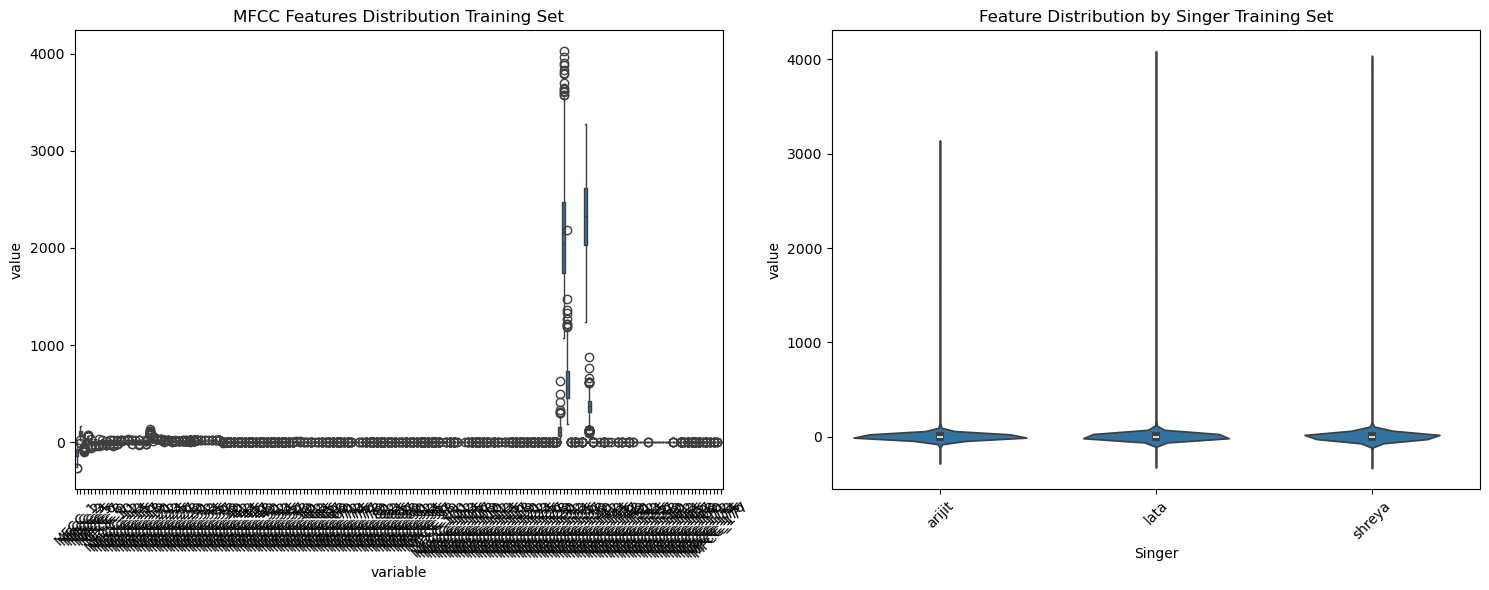

In [13]:
# Visualize MFCC feature distributions
plt.figure(figsize=(15, 6))
features_df = pd.DataFrame(X_train, columns=[f'MFCC_{i+1}' for i in range(X_train.shape[1])])
features_df['Singer'] = [singer_names_train[i] for i in y_train]

plt.subplot(1, 2, 1)
sns.boxplot(data=features_df.melt(id_vars=['Singer']), x='variable', y='value')
plt.xticks(rotation=45)
plt.title('MFCC Features Distribution Training Set')

plt.subplot(1, 2, 2)
sns.violinplot(data=features_df.melt(id_vars=['Singer']), x='Singer', y='value')
plt.xticks(rotation=45)
plt.title('Feature Distribution by Singer Training Set')
plt.tight_layout()
plt.show()

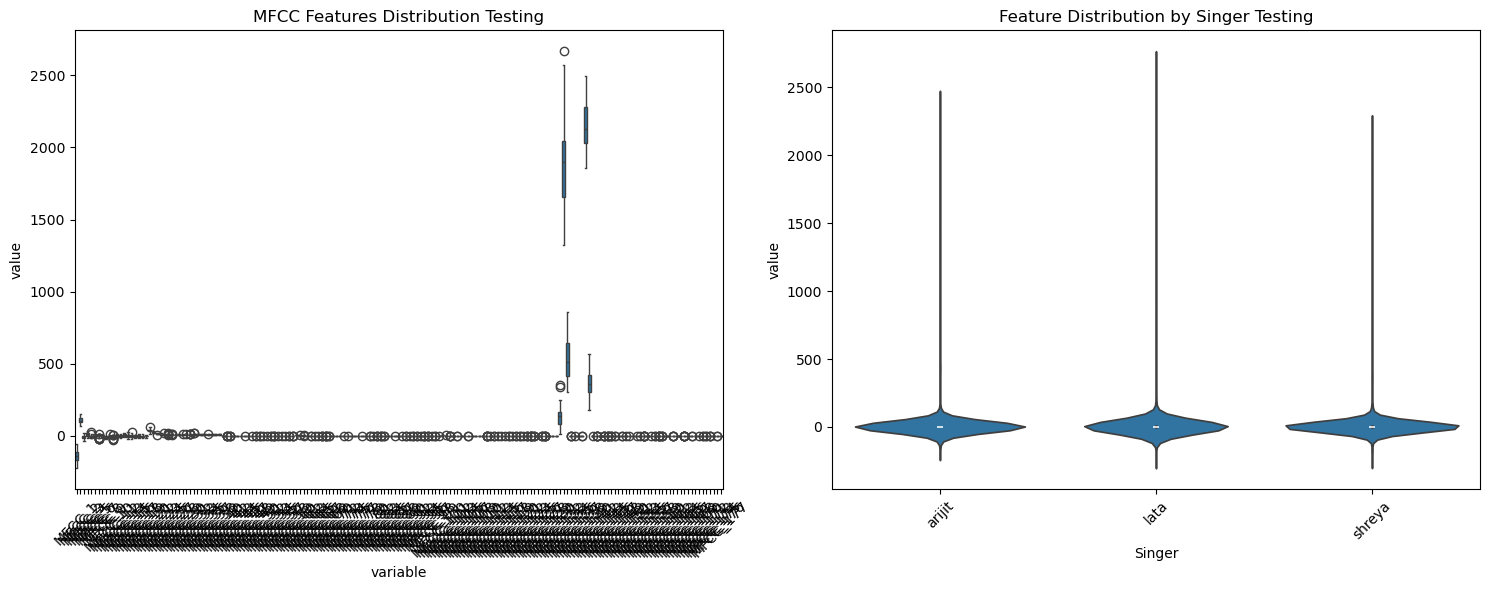

In [14]:
# Visualize MFCC feature distributions
plt.figure(figsize=(15, 6))
features_df = pd.DataFrame(X_test, columns=[f'MFCC_{i+1}' for i in range(X_test.shape[1])])
features_df['Singer'] = [singer_names_test[i] for i in y_test]

plt.subplot(1, 2, 1)
sns.boxplot(data=features_df.melt(id_vars=['Singer']), x='variable', y='value')
plt.xticks(rotation=45)
plt.title('MFCC Features Distribution Testing')

plt.subplot(1, 2, 2)
sns.violinplot(data=features_df.melt(id_vars=['Singer']), x='Singer', y='value')
plt.xticks(rotation=45)
plt.title('Feature Distribution by Singer Testing')
plt.tight_layout()
plt.show()

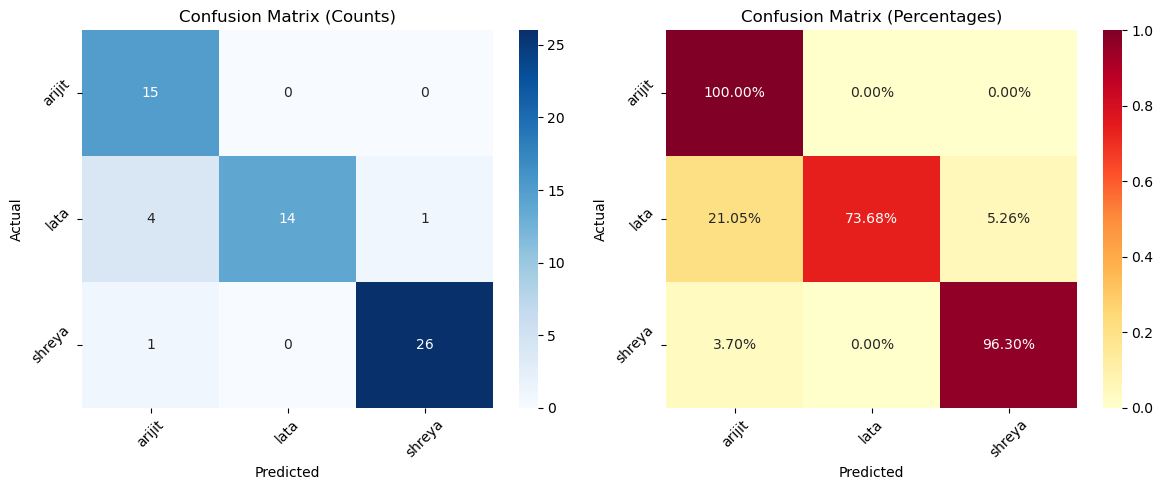

Exception ignored in: <function ResourceTracker.__del__ at 0x7fcc9e8a2b60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fb4c599eb60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fb64399eb60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

In [15]:
# Enhanced confusion matrix visualization
def plot_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 5))
    
    # Absolute numbers
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=singer_names_test,
                yticklabels=singer_names_test)
    plt.title('Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # Percentages
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=singer_names_test,
                yticklabels=singer_names_test)
    plt.title('Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix()